In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from tqdm import tqdm
import math

import pycbc
from pycbc.types.timeseries import TimeSeries
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter.resample import resample_to_delta_t
from pycbc.events import ThresholdCluster
from pycbc.filter import matched_filter, resample_to_delta_t, highpass_fir
from pycbc.vetoes import power_chisq
from pycbc.filter.matchedfilter import sigma
from pycbc.events.ranking import newsnr

from tempgen import *
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import tukey

In [2]:
import matplotlib.colors as colors

def plot_4Ms(DF, col='$D_{h}$ [kpc]', ax=None, legend=False, marker='o'):
    
    plt.rcParams.update({'figure.figsize':(7.5,5), 'figure.dpi':100, "figure.autolayout": True, "axes.edgecolor":'black'})
    if ax is None:
        fig, ax = plt.subplots(2,2, figsize=(20,15))
        
    df = DF.copy()
    
    df['Qi'] = 10**df['Qi']
    
    vmin, vmax = 1, df['Dh'].max()
    
    df.rename(columns = {'Dh':'$D_{h}$ [kpc]'}, inplace = True)

    
    
    x = [0,0,1,1]
    y = [0,1,0,1]
    m = [1,10,25,50]
    
    for i in range(4):
        
        AX = ax[x[i], y[i]]
        
        j2 = df[df['M'] == m[i]]
        
        j = j2[j2['$D_{h}$ [kpc]'] >= 10]
        p = j.plot.scatter(x='ri', y='Qi', c=col, norm=colors.LogNorm(vmin = vmin, vmax=vmax), legend=False, label=legend, marker=marker, ax=AX)
        
        j = j2[j2['$D_{h}$ [kpc]'] < 10]
        p = j.plot.scatter(x='ri', y='Qi', c='r', legend=False, label=legend, marker='x', ax=AX)
        
        colorbar_kw={'label': 'colorbar from lines'}
        AX.set_title('M = ' + str(m[i]) + ' Ms', fontweight='bold')
        AX.set_xlim(0,6.5)
        AX.set_ylim(10**(-8.5),10**(-5))
        AX.set_xlabel('$r_{i}$ [pc]')
        AX.set_ylabel('$\u03B8_{i}$')
        AX.set_yscale('log')
        if legend:
            AX.legend()
            
        
            

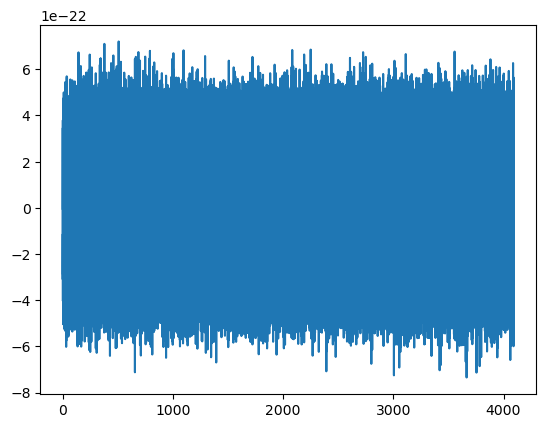

In [3]:
flow = 20
fhigh = 250

strain = TimeSeries(np.loadtxt('Gaussian_4096s_512Hz.txt'), delta_t=1/512)
strain = strain.highpass_fir(flow, 512).lowpass_fir(fhigh, 512)
strain.start_time=0
strain.plot()


In [4]:
df = pd.read_csv('prop_durs.csv')
df['dur'] = df['dur'].apply(math.ceil)
df

,Qi,ri,M,amps,dur
0,-8.0,1.0,1,2.451429e-14,1
1,-8.0,2.0,1,6.128572e-15,1
2,-8.0,3.0,1,2.723809e-15,1
3,-8.0,4.0,1,1.532142e-15,2
4,-8.0,5.0,1,9.805706e-16,3
...,...,...,...,...,...
75,-6.0,2.0,50,7.660711e-14,63
76,-6.0,3.0,50,3.404757e-14,211
77,-6.0,4.0,50,1.915174e-14,499
78,-6.0,5.0,50,1.225709e-14,972


In [5]:
Dur = strain.time_slice(0, 8)
Dur.duration

8.0

In [7]:
from pycbc.filter.matchedfilter import sigma

hd = h5py.File('Prop_temps.hdf5', 'r')

Hp = hd['Hp']
Hc = hd['Hc']

DH = []

#fig, ax = plt.subplots(1,2, figsize=(20, 5))

for i, z in zip(range(df.shape[0]), tqdm(range(df.shape[0]))):
    
    j = df.iloc[i]
    M = j['M']
    r = j['ri']
    Q = j['Qi']
    dur = j['dur']
    
    
    hp = TimeSeries(np.array(Hp[str(i)]), delta_t=1/512)
    hp *= tukey(len(hp), 0.25)
    
    if hp.duration < 8:
        hp.resize(len(Dur))
    
    PSD = interpolate(strain.psd(4), hp.delta_f)
    PSD = inverse_spectrum_truncation(PSD, int(4 * strain.sample_rate), trunc_method='hann')
    Dh = sigma(hp, PSD, low_frequency_cutoff=30, high_frequency_cutoff=250)/(8)
    DH.append(Dh)

 99%|██████████████████████████████████████████▍| 79/80 [00:23<00:00,  3.42it/s]


In [8]:
df['Dh'] = DH

In [9]:
df.to_csv('new_Horizon.csv', index=False)

In [10]:
df

,Qi,ri,M,amps,dur,Dh
0,-8.0,1.0,1,2.451429e-14,1,3.701643e+07
1,-8.0,2.0,1,6.128572e-15,1,8.375372e+06
2,-8.0,3.0,1,2.723809e-15,1,1.896139e+06
3,-8.0,4.0,1,1.532142e-15,2,1.742237e+05
4,-8.0,5.0,1,9.805706e-16,3,3.890821e+03
...,...,...,...,...,...,...
75,-6.0,2.0,50,7.660711e-14,63,2.748473e+00
76,-6.0,3.0,50,3.404757e-14,211,4.013539e-01
77,-6.0,4.0,50,1.915174e-14,499,1.992907e-01
78,-6.0,5.0,50,1.225709e-14,972,1.078803e-01


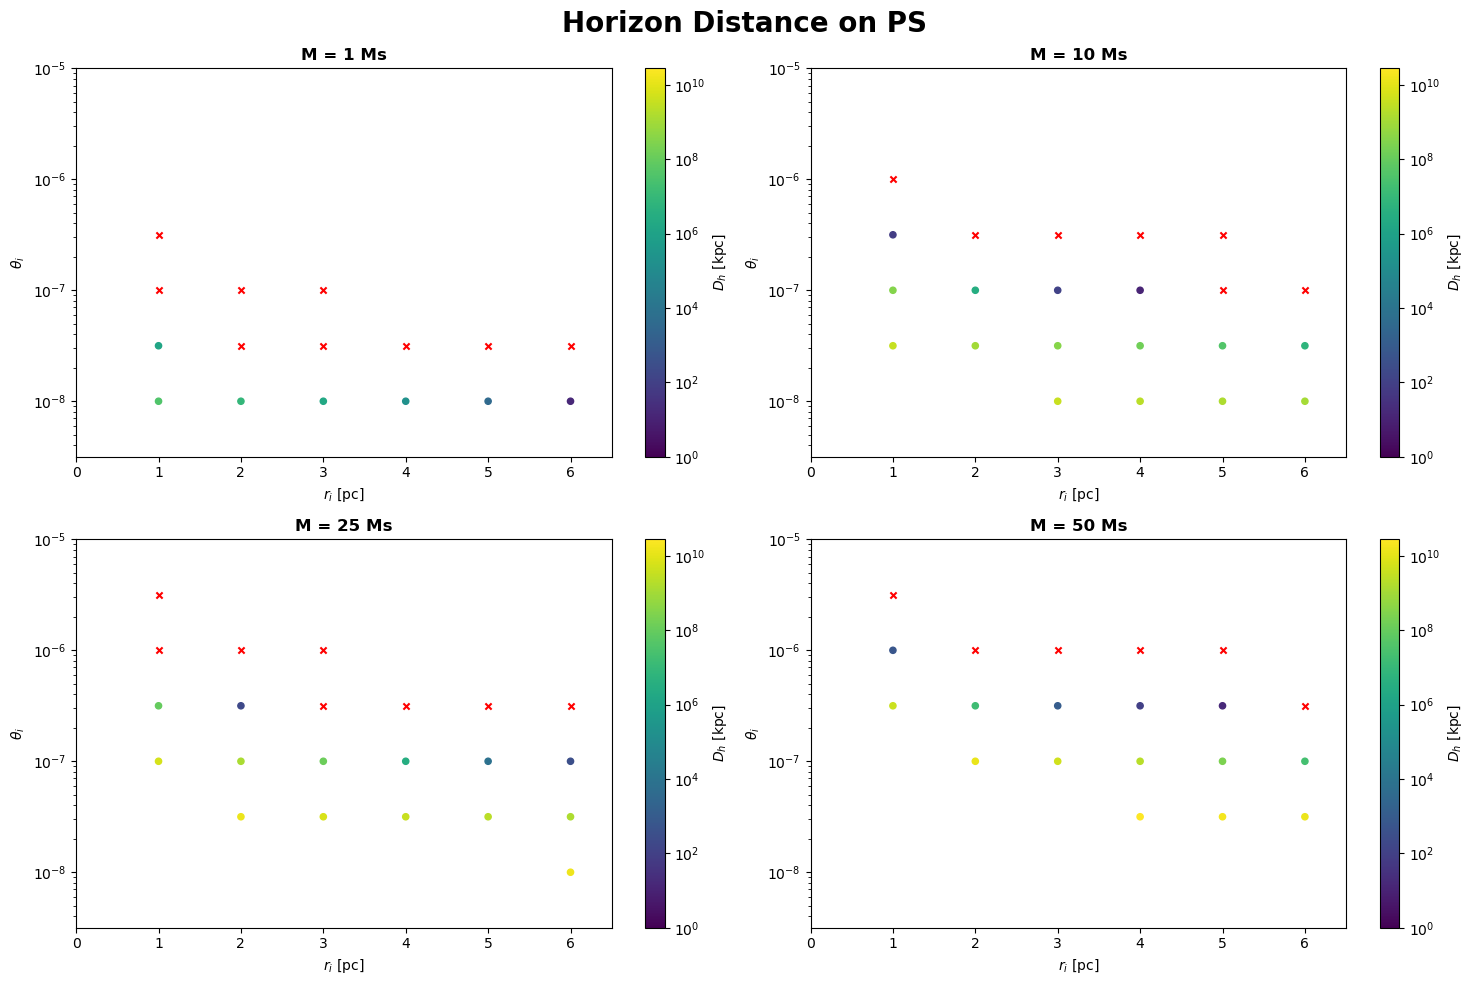

In [28]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
plot_4Ms(df, ax=ax)
#plot_4Ms(DF[DF['Dh'] < 100], col='r', ax=ax, legend='Dh < 1 kpc')

fig.suptitle('Horizon Distance on PS', fontweight='bold', fontsize=20)
fig.tight_layout(h_pad=3)
plt.savefig('Horizon_PS.jpg')

In [12]:
df[df['Dh'] > 10]['dur'].max()

31

In [13]:
df[(df['M'] == 25) & (df['ri'] == 2) & (df['Qi'] == -6)]

,Qi,ri,M,amps,dur,Dh
57,-6.0,2.0,25,9.575868e-15,250,0.073637


In [14]:
df[(df['M'] == 25) & (df['ri'] == 2) & (df['Qi'] == -6.5)]

,Qi,ri,M,amps,dur,Dh
51,-6.5,2.0,25,9.575893e-14,8,194.575428


In [26]:
pc=3.08*10**(16)
G=6.67*10**(-11)
c=3*10**8
Ms=1.98*10**(30)

vi= np.sqrt(G*(5*10**5)*Ms/(3* 10*pc))


def impact(M, ri, Qi, vi = vi):
    
    Qi = 10**(Qi)
    L = ri*vi*np.sin(Qi)
    
    e = 1 + (L*vi/G/M)**2 * (1 - 2*(G*M/vi**2)/ri)
    e = np.sqrt(e)
    
    a = 1/(2/ri - vi**2/(G*M))
    
    b = -a*np.sqrt(e**2  - 1)

    return b**2


df['impact'] = df.apply(lambda x: impact(x['M'], x['ri'], x['Qi']), axis=1)
df

,Qi,ri,M,amps,dur,Dh,impact
0,-8.0,1.0,1,2.451429e-14,1,3.701643e+07,1.000000e-16
1,-8.0,2.0,1,6.128572e-15,1,8.375372e+06,4.000000e-16
2,-8.0,3.0,1,2.723809e-15,1,1.896139e+06,9.000000e-16
3,-8.0,4.0,1,1.532142e-15,2,1.742237e+05,1.600000e-15
4,-8.0,5.0,1,9.805706e-16,3,3.890821e+03,2.500000e-15
...,...,...,...,...,...,...,...
75,-6.0,2.0,50,7.660711e-14,63,2.748473e+00,4.000000e-12
76,-6.0,3.0,50,3.404757e-14,211,4.013539e-01,9.000000e-12
77,-6.0,4.0,50,1.915174e-14,499,1.992907e-01,1.600000e-11
78,-6.0,5.0,50,1.225709e-14,972,1.078803e-01,2.500000e-11


<Axes: xlabel='impact', ylabel='Dh'>

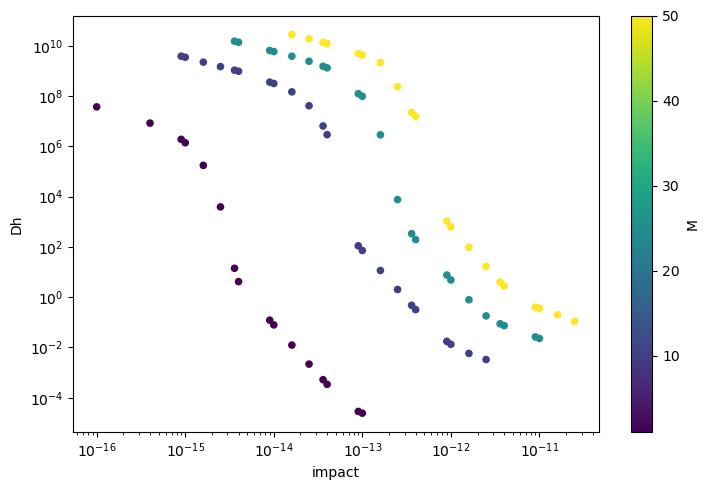

In [27]:
df.plot.scatter(x='impact', y='Dh', logy=True, c='M', logx=True, cmap='viridis')